In [9]:
import sys
import os
from pathlib import Path

from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn_som.som import SOM

# from sklearn.model_selection import GridSearchCV
from itertools import product
# внутренние
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
# внешние
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import fowlkes_mallows_score


if (dir := str(Path(os.getcwd()).parent)) not in sys.path:
    sys.path.append(dir)

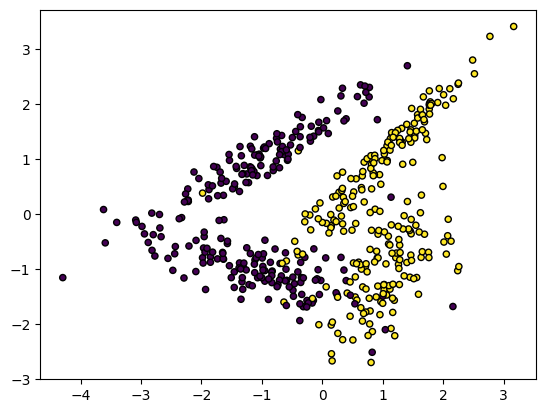

In [10]:
data1, data1_y = make_classification(
    n_samples=500,
    n_classes=2,
    n_features=7,
    n_informative=2,
    random_state=73
)
plt.scatter(data1[:, 0], data1[:, 1], marker='o', c=data1_y, s=20, edgecolor='k')
plt.show()

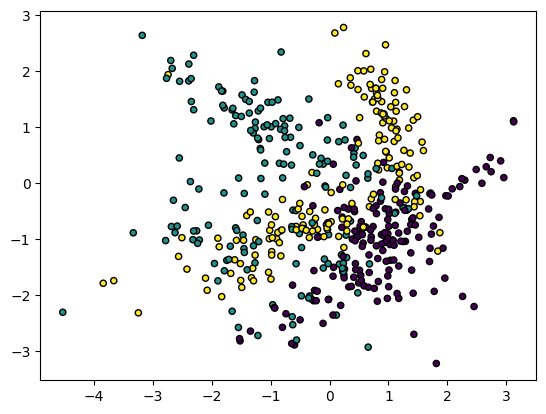

In [11]:
data2, data2_y = make_classification(
    n_samples=500,
    n_classes=3,
    n_clusters_per_class=2,
    n_features=3,
    n_informative=3,
    n_redundant=0,
    flip_y=0.01,
    random_state=73
)
plt.scatter(data2[:, 0], data2[:, 1], marker='o', c=data2_y, s=20, edgecolor='k')
plt.show()

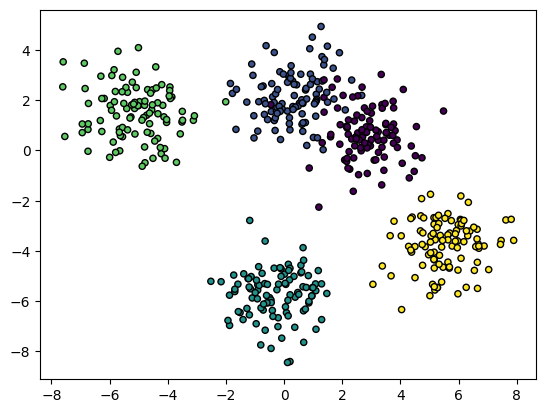

In [12]:
data3, data3_y = make_blobs(
    n_samples=500,
    centers=5,
    random_state=73,
)
plt.scatter(data3[:, 0], data3[:, 1], marker='o', c=data3_y, s=20, edgecolor='k')
plt.show()

## Вспомогательные функции

In [13]:
def print_metrics(data, data_y, estimator_labels):
    print(
        f"""
= + = + = + = + Внешние метрики + = + = + = + =
{'rand_score':>23} = {rand_score(estimator_labels, data_y):.5f}\t (-> 1)
{'fowlkes_mallows_score':>23} = {fowlkes_mallows_score(estimator_labels, data_y):.5f}\t (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
{'silhouette_score':>23} = {silhouette_score(data, estimator_labels):.5f}\t (-> 1)
{'davies_bouldin_score':>23} = {davies_bouldin_score(data, estimator_labels):.5f}\t (-> 0)
"""
    )

In [14]:
def grid_search(params: dict):
    """
    yield grid of params
    """
    param_grid = [product([k], np.unique(v)) for k, v in params.items()]
    for grid in product(*param_grid):  # sorted(product(*param_grid), key=lambda x: x[1:])
        yield dict(tuple(grid))

params = {
    "p1": [4, 5],
    'p2': [10, 11],
    'p3': [-1],
}

print(*grid_search(params))

{'p1': 4, 'p2': 10, 'p3': -1} {'p1': 4, 'p2': 11, 'p3': -1} {'p1': 5, 'p2': 10, 'p3': -1} {'p1': 5, 'p2': 11, 'p3': -1}


In [15]:
def find_best(estimator, data, params: dict = {}):
    """
    Поиск по сетке (max silhouette_score)
    """
    res = []
    for grid in grid_search(params):
        model = estimator(**grid).fit(data)
        res.append(
            {
                'silhouette_score': silhouette_score(data, model.labels_),
                'model': model,
                'params': grid
            }
        )

    return max(res, key=lambda x: x['silhouette_score'])

## KMeans

In [27]:
from mylib.kmeans import KMeans as KM

## data1


= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.55030	 (-> 1)
  fowlkes_mallows_score = 0.55382	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.28065	 (-> 1)
   davies_bouldin_score = 1.34418	 (-> 0)



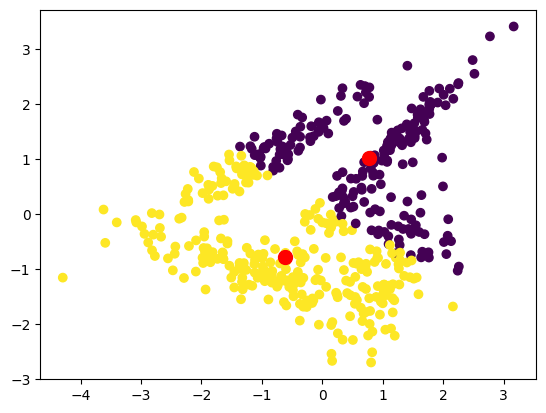

In [28]:
km1 = KM(n_clusters=2).fit(data1)

print_metrics(data1, data1_y, km1.labels_)

plt.scatter(data1[:, 0], data1[:, 1], c=km1.labels_)
plt.scatter(km1.cluster_centers_[:, 0], km1.cluster_centers_[:, 1], s=100, c='red')


= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.55030	 (-> 1)
  fowlkes_mallows_score = 0.55382	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.28065	 (-> 1)
   davies_bouldin_score = 1.34418	 (-> 0)



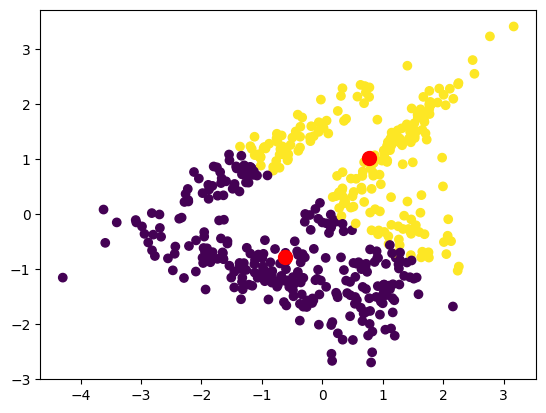

In [29]:
kmeans1 = KMeans(n_clusters=2, n_init='auto').fit(data1)

plt.scatter(data1[:, 0], data1[:, 1], c=kmeans1.labels_)
plt.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=100, c='red')

print_metrics(data1, data1_y, kmeans1.labels_)

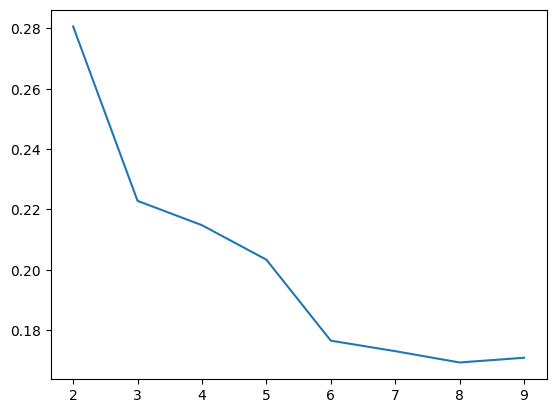

In [30]:
plt.plot(range(2, 10), [silhouette_score(data1, KMeans(i, n_init='auto').fit(data1).labels_) for i in range(2, 10)])

In [31]:
params = {
    'n_clusters': range(2, 10),
    'max_iter': range(200, 401, 20),
    'verbose': [0],
    'init': ['k-means++', 'random'],
    'n_init': ['auto'],
    'random_state': [73],
}

print(find_best(KMeans, data1, params))

# scores = [[] for _ in range(22)]
# grids = list(grid_search(params))
# for i, grid in enumerate(grids):
#     model = KMeans(**grid).fit(data1)
#     scores[i % 22].append(silhouette_score(data1, model.labels_))
# for score in scores:
#     plt.plot(range(2, 10), score)

{'silhouette_score': 0.28064521943660214, 'model': KMeans(max_iter=200, n_clusters=2, n_init='auto', random_state=73), 'params': {'n_clusters': 2, 'max_iter': 200, 'verbose': 0, 'init': 'k-means++', 'n_init': 'auto', 'random_state': 73}}


{'silhouette_score': 0.1711492589843938, 'model': AffinityPropagation(damping=0.6, random_state=73), 'params': {'damping': 0.6, 'verbose': False, 'random_state': 73}}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.52120	 (-> 1)
  fowlkes_mallows_score = 0.20604	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.17115	 (-> 1)
   davies_bouldin_score = 1.28319	 (-> 0)



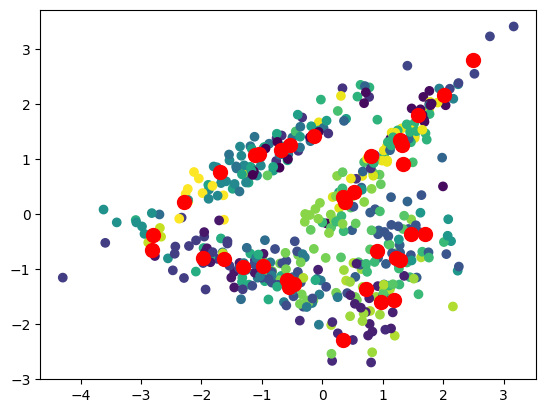

In [33]:
params = {
    'damping': np.arange(0.5, 1, 0.1),
    # 'preference': np.arange(-100, 0, 10),
    # 'max_iter': range(130, 231, 10),
    # 'convergence_iter': range(9, 19, 3),
    'verbose': [False],
    'random_state': [73],
}

best = find_best(AffinityPropagation, data1, params)
print(best)

afp1: AffinityPropagation = best['model']

plt.scatter(data1[:, 0], data1[:, 1], c=afp1.labels_)
plt.scatter(afp1.cluster_centers_[:, 0], afp1.cluster_centers_[:, 1], s=100, c='red')

print_metrics(data1, data1_y, afp1.labels_)

##### нормальный дбскан

[[0.         1.00864662 1.21676197 1.31374844 1.37853408]
 [0.         0.56929119 0.69619932 0.88061861 1.03106772]
 [0.         0.46699863 0.6159993  0.97947747 1.02858673]
 ...
 [0.         2.14729477 2.19025177 2.21614898 2.36129342]
 [0.         1.09862394 1.44231906 1.44768235 1.50167553]
 [0.         1.06855671 1.09108938 1.1824804  1.28260763]] [[  0 287  29 130 125]
 [  1 377 314 182 334]
 [  2 459 127 395 186]
 ...
 [497 195 422  20 354]
 [498 323 307 423 491]
 [499 158 327 400 343]]


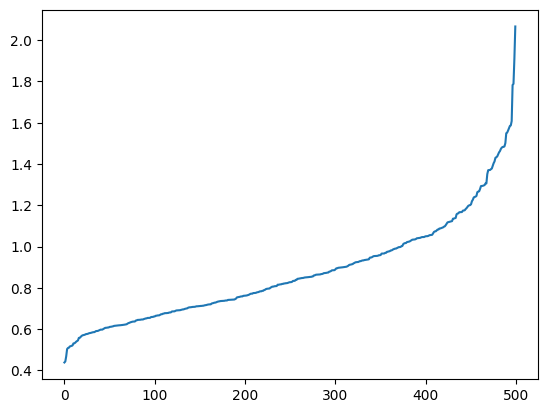

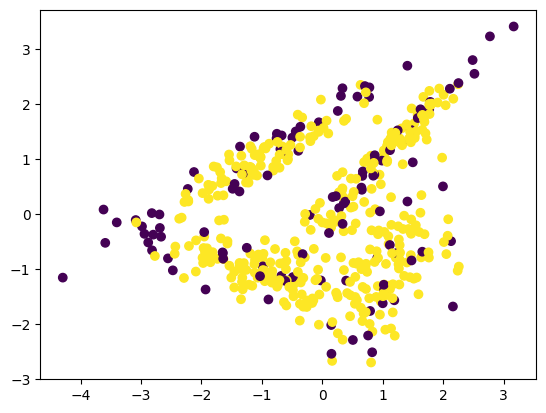

In [31]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(data1)
distances, indices = nn.kneighbors(data1)
print(distances, indices)

distances = np.sort(np.mean(distances, axis=1))
plt.plot(distances)
plt.show()

dbscan_ = DBSCAN(eps=1.26, min_samples=5).fit(data1)
plt.scatter(data1[:, 0], data1[:, 1], c=dbscan_.labels_)

#####

{'silhouette_score': 0.3852501695568131, 'model': DBSCAN(eps=1.9000000000000008, leaf_size=15, min_samples=3), 'params': {'eps': 1.9000000000000008, 'min_samples': 3, 'leaf_size': 15}}
[-1  0]

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.49903	 (-> 1)
  fowlkes_mallows_score = 0.69935	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.38525	 (-> 1)
   davies_bouldin_score = 3.42347	 (-> 0)



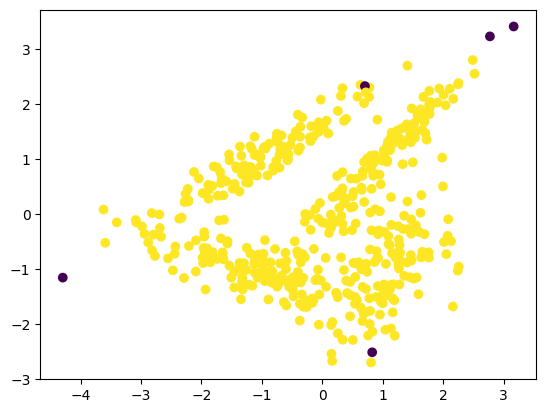

In [47]:
params = {
    'eps': np.arange(1, 2.2, 0.1),
    'min_samples': range(3, 8),
    'leaf_size': range(15, 41, 5),
}

best = find_best(DBSCAN, data1, params)
print(best)

dbscan1: DBSCAN = best['model']

print(np.unique(dbscan1.labels_))
plt.scatter(data1[:, 0], data1[:, 1], c=dbscan1.labels_)

print_metrics(data1, data1_y, dbscan1.labels_)

{'silhouette_score': 0.22461514585136183, 'model': GaussianMixture(n_components=2), 'params': {'n_components': 2}}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.50621	 (-> 1)
  fowlkes_mallows_score = 0.50903	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.22462	 (-> 1)
   davies_bouldin_score = 1.71149	 (-> 0)



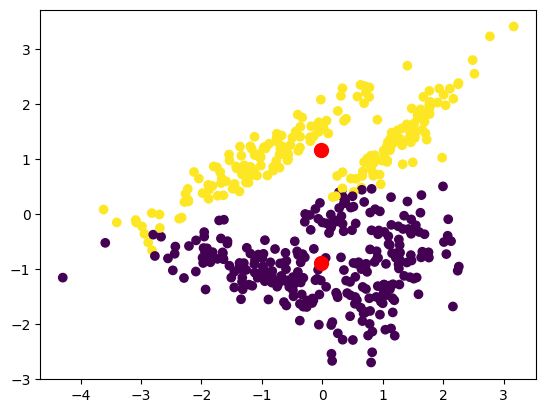

In [49]:
params = {
    'n_components': [2, 3, 4, 5],
}

res = []
for grid in grid_search(params):
    model = GaussianMixture(**grid).fit(data1)
    res.append({
        'silhouette_score': silhouette_score(data1, model.predict(data1)),
        'model': model,
        'params': grid,
    })

best = max(res, key=lambda x: x['silhouette_score'])
print(best)

gm1: GaussianMixture = best['model']

plt.scatter(data1[:, 0], data1[:, 1], c=gm1.predict(data1))

print_metrics(data1, data1_y, gm1.predict(data1))
plt.scatter(gm1.means_[:, 0], gm1.means_[:, 1], s=100, c='red')

{'n_components': 2}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.50621	 (-> 1)
  fowlkes_mallows_score = 0.50903	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.22462	 (-> 1)
   davies_bouldin_score = 1.71149	 (-> 0)



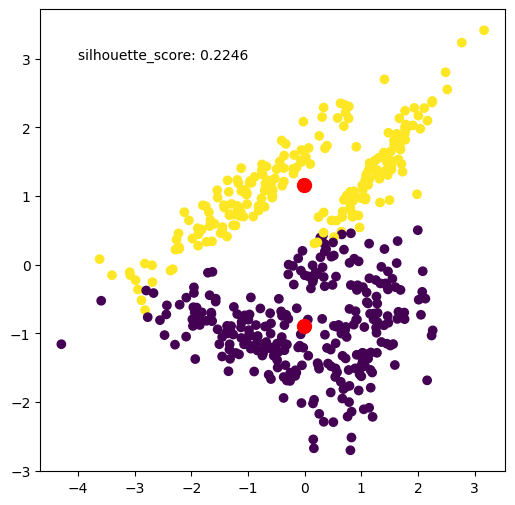

{'n_components': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.77534	 (-> 1)
  fowlkes_mallows_score = 0.74981	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.14940	 (-> 1)
   davies_bouldin_score = 1.81111	 (-> 0)



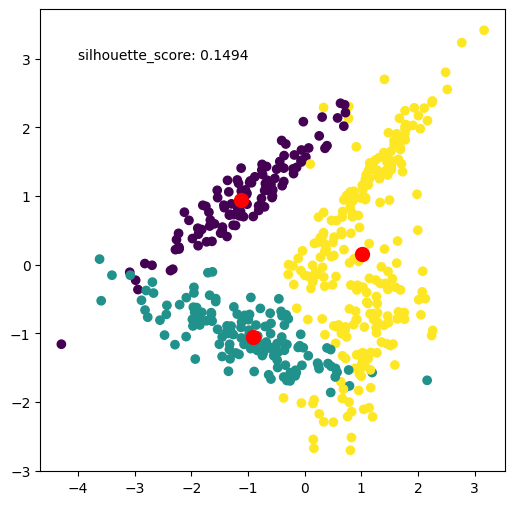

{'n_components': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.70645	 (-> 1)
  fowlkes_mallows_score = 0.64458	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.15279	 (-> 1)
   davies_bouldin_score = 1.73399	 (-> 0)



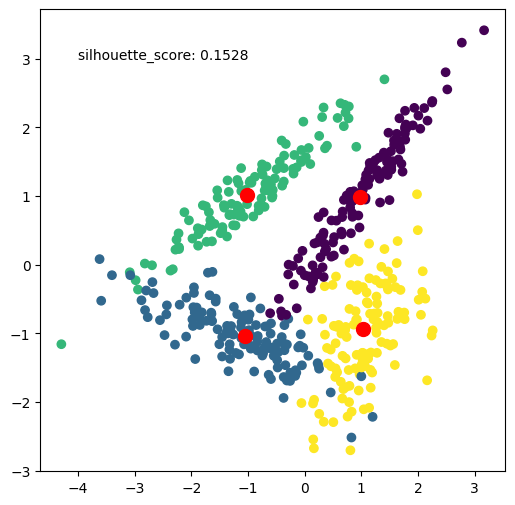

{'n_components': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.67113	 (-> 1)
  fowlkes_mallows_score = 0.58721	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.10502	 (-> 1)
   davies_bouldin_score = 1.99277	 (-> 0)



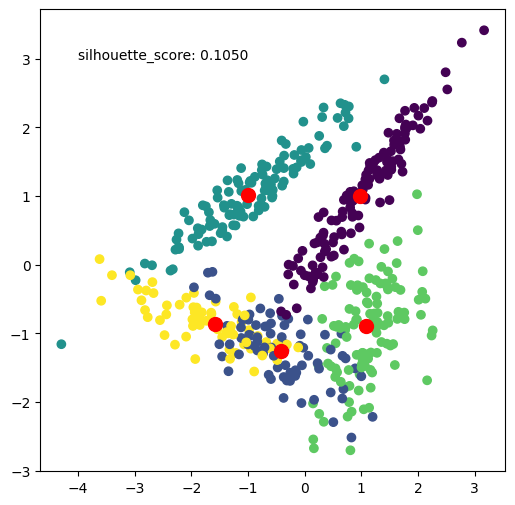

In [195]:

params = {
    'n_components': [2, 3, 4, 5],
}

res = []
for grid in grid_search(params):
    model = GaussianMixture(**grid).fit(data1)
    res.append({
        'silhouette_score': silhouette_score(data1, model.predict(data1)),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data1, data1_y, info['model'].predict(data1))
    plt.figure(figsize=(6, 6))
    plt.scatter(data1[:, 0], data1[:, 1], c=info['model'].predict(data1))
    plt.scatter(info['model'].means_[:, 0], info['model'].means_[:, 1], s=100, c='red')
    plt.text(-4, 3, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

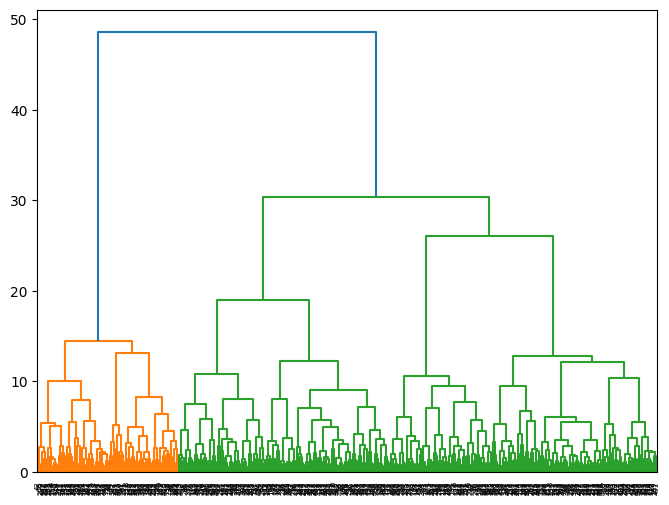

In [75]:
clusters1 = hierarchy.linkage(data1, method="ward")
plt.figure(figsize=(8, 6))
dendrogram1 = hierarchy.dendrogram(clusters1)
plt.show(dendrogram1)

{'silhouette_score': 0.27706863833614526, 'model': AgglomerativeClustering()}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.53716	 (-> 1)
  fowlkes_mallows_score = 0.60127	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.27707	 (-> 1)
   davies_bouldin_score = 1.23920	 (-> 0)



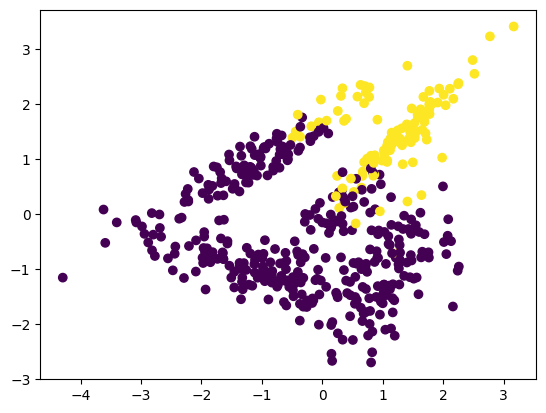

In [70]:
params = {
    'n_clusters': [2, 3, 4, 5],
}

best = find_best(AgglomerativeClustering, data1, params)
print(best)

agc1: AgglomerativeClustering = best['model']

plt.scatter(data1[:, 0], data1[:, 1], c=agc1.labels_)
print_metrics(data1, data1_y, agc1.labels_)

{'n_clusters': 2}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.53716	 (-> 1)
  fowlkes_mallows_score = 0.60127	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.27707	 (-> 1)
   davies_bouldin_score = 1.23920	 (-> 0)



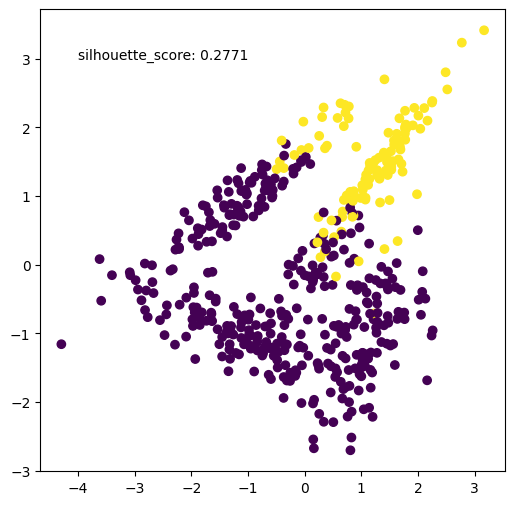

{'n_clusters': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.71800	 (-> 1)
  fowlkes_mallows_score = 0.67905	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.18240	 (-> 1)
   davies_bouldin_score = 1.74305	 (-> 0)



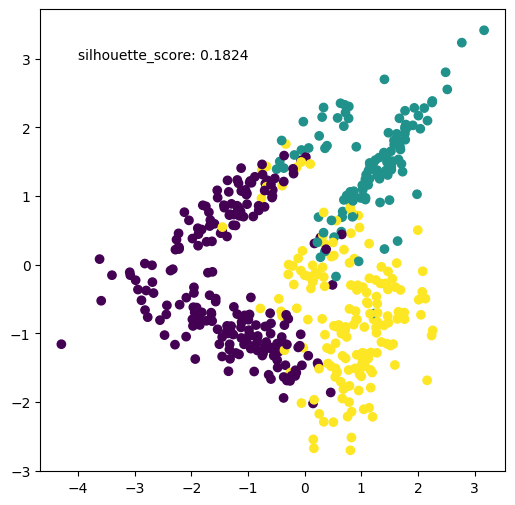

{'n_clusters': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.65141	 (-> 1)
  fowlkes_mallows_score = 0.57102	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.18941	 (-> 1)
   davies_bouldin_score = 1.49530	 (-> 0)



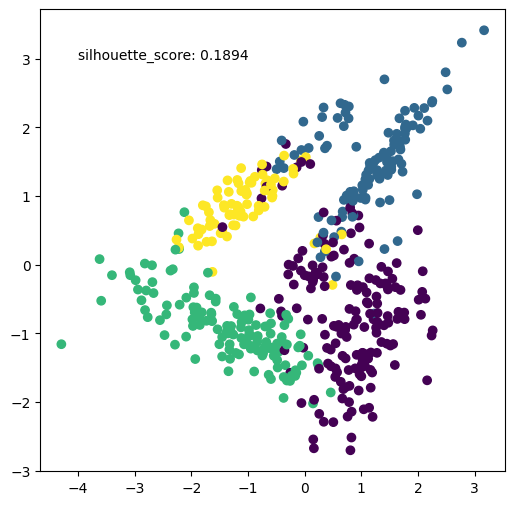

{'n_clusters': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.62353	 (-> 1)
  fowlkes_mallows_score = 0.51301	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.16160	 (-> 1)
   davies_bouldin_score = 1.62842	 (-> 0)



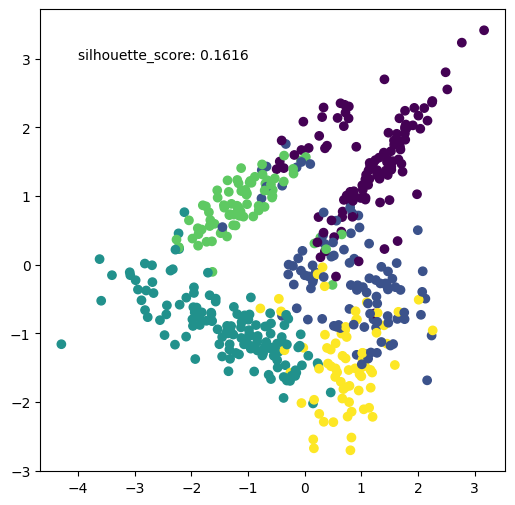

In [196]:
params = {
    'n_clusters': [2, 3, 4, 5],
}

res = []
for grid in grid_search(params):
    model = AgglomerativeClustering(**grid).fit(data1)
    res.append({
        'silhouette_score': silhouette_score(data1, model.labels_),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data1, data1_y, info['model'].labels_)
    plt.figure(figsize=(6, 6))
    plt.scatter(data1[:, 0], data1[:, 1], c=info['model'].labels_)
    plt.text(-4, 3, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

In [86]:
params = {
    'dim': [7],
    'random_state': [73],
    'n': range(3, 6),
    'm': range(3, 6),
    'lr': [1, 2, 3],
    'sigma': [1, 2, 3],
}

res = []
for grid in grid_search(params):
    model: SOM = SOM(**grid)
    res.append({
        'silhouette_score': silhouette_score(data1, model.fit_predict(data1)),
        'model': model,
        'params': grid,
    })

best = max(res, key=lambda x: x['silhouette_score'])
print(best)

som1: SOM = best['model']
print_metrics(data1, data1_y, som1.predict(data1))

{'silhouette_score': 0.11698373922993532, 'model': <sklearn_som.som.SOM object at 0x00000220363BB5E0>, 'params': {'dim': 7, 'random_state': 73, 'n': 3, 'm': 3, 'lr': 3, 'sigma': 1}}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.56861	 (-> 1)
  fowlkes_mallows_score = 0.38516	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.11698	 (-> 1)
   davies_bouldin_score = 1.80627	 (-> 0)



{'dim': 7, 'random_state': 73, 'n': 3, 'm': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.57530	 (-> 1)
  fowlkes_mallows_score = 0.39765	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.09057	 (-> 1)
   davies_bouldin_score = 2.14168	 (-> 0)



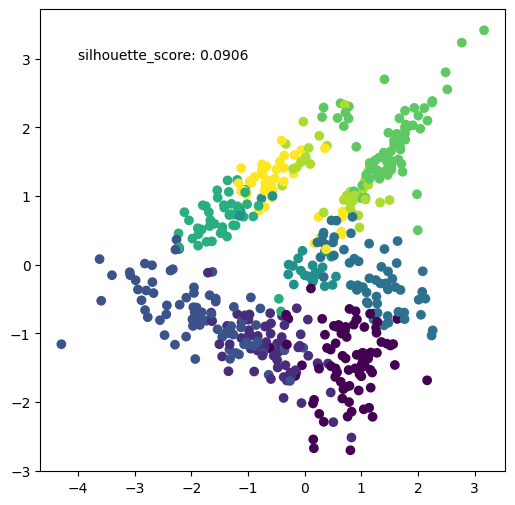

{'dim': 7, 'random_state': 73, 'n': 3, 'm': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.54947	 (-> 1)
  fowlkes_mallows_score = 0.32566	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.07907	 (-> 1)
   davies_bouldin_score = 2.07420	 (-> 0)



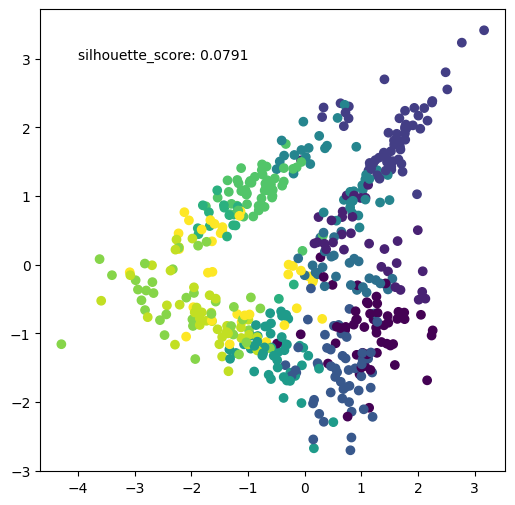

{'dim': 7, 'random_state': 73, 'n': 3, 'm': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.54524	 (-> 1)
  fowlkes_mallows_score = 0.31020	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.06039	 (-> 1)
   davies_bouldin_score = 2.04257	 (-> 0)



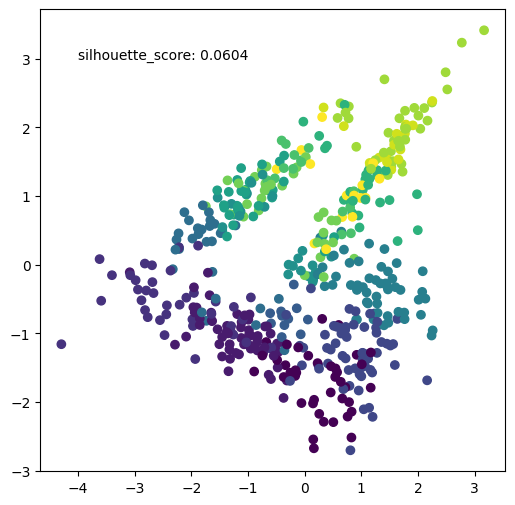

{'dim': 7, 'random_state': 73, 'n': 4, 'm': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.55581	 (-> 1)
  fowlkes_mallows_score = 0.34198	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.07480	 (-> 1)
   davies_bouldin_score = 2.27824	 (-> 0)



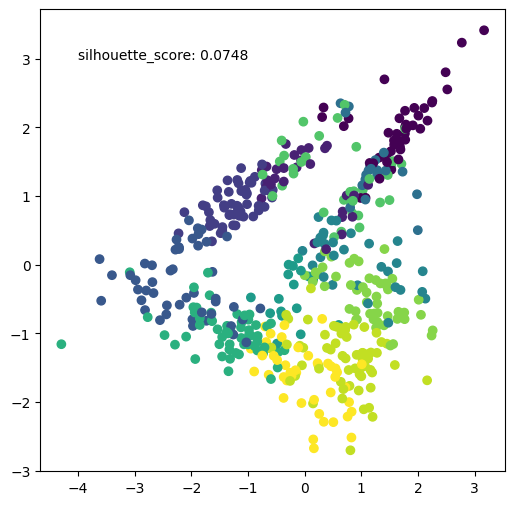

{'dim': 7, 'random_state': 73, 'n': 4, 'm': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.54119	 (-> 1)
  fowlkes_mallows_score = 0.29169	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.06921	 (-> 1)
   davies_bouldin_score = 2.09063	 (-> 0)



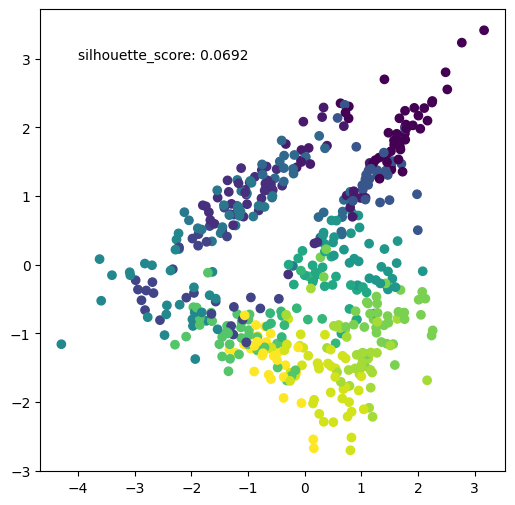

{'dim': 7, 'random_state': 73, 'n': 4, 'm': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.53149	 (-> 1)
  fowlkes_mallows_score = 0.25538	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.07797	 (-> 1)
   davies_bouldin_score = 2.04809	 (-> 0)



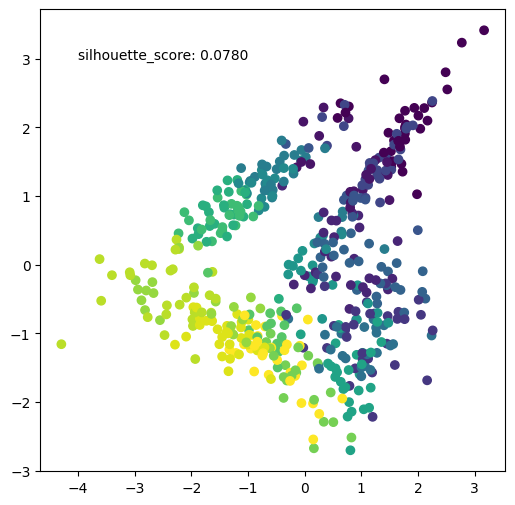

{'dim': 7, 'random_state': 73, 'n': 5, 'm': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.54212	 (-> 1)
  fowlkes_mallows_score = 0.29853	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.08480	 (-> 1)
   davies_bouldin_score = 1.93845	 (-> 0)



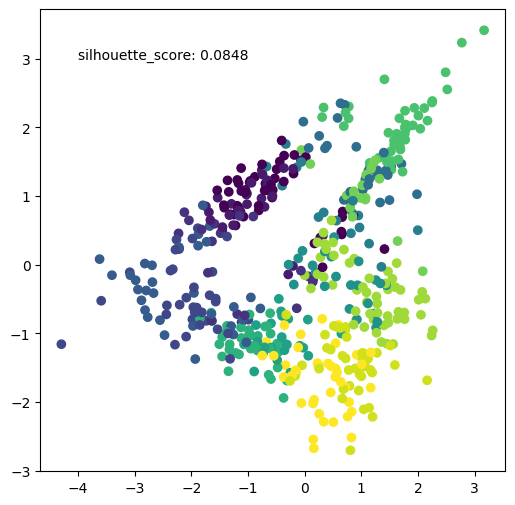

{'dim': 7, 'random_state': 73, 'n': 5, 'm': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.53451	 (-> 1)
  fowlkes_mallows_score = 0.26619	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.07242	 (-> 1)
   davies_bouldin_score = 1.96786	 (-> 0)



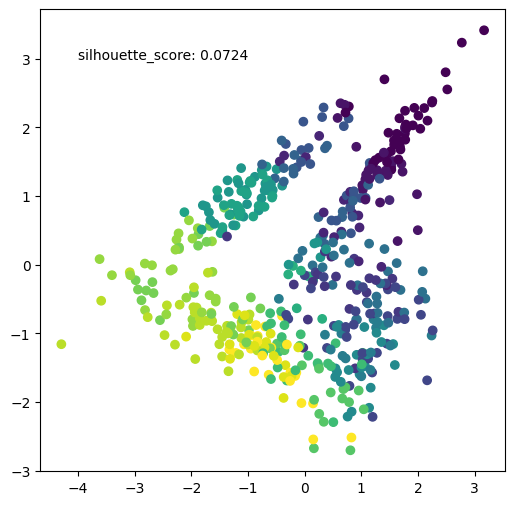

{'dim': 7, 'random_state': 73, 'n': 5, 'm': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.52366	 (-> 1)
  fowlkes_mallows_score = 0.22271	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.07188	 (-> 1)
   davies_bouldin_score = 1.94718	 (-> 0)



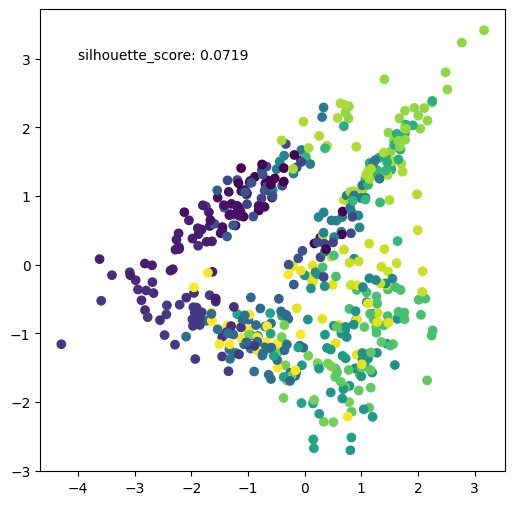

In [197]:

params = {
    'dim': [7],
    'random_state': [73],
    'n': range(3, 6),
    'm': range(3, 6),
}

res = []
for grid in grid_search(params):
    model = SOM(**grid)
    res.append({
        'silhouette_score': silhouette_score(data1, model.fit_predict(data1)),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data1, data1_y, info['model'].predict(data1))
    plt.figure(figsize=(6, 6))
    plt.scatter(data1[:, 0], data1[:, 1], c=info['model'].predict(data1))
    plt.text(-4, 3, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

## data2


= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.58624	 (-> 1)
  fowlkes_mallows_score = 0.39576	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.27707	 (-> 1)
   davies_bouldin_score = 1.29632	 (-> 0)



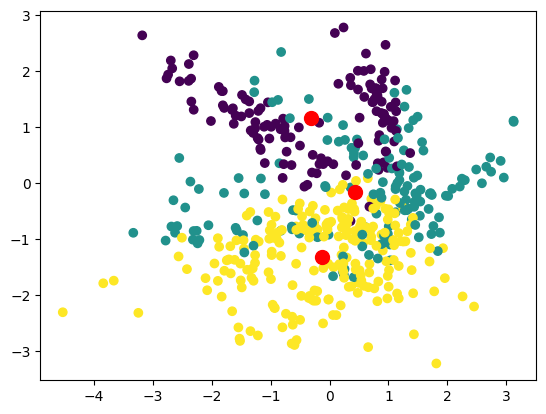

In [108]:
km2 = KM(n_clusters=3).fit(data2)

print_metrics(data2, data2_y, km2.labels_)

plt.scatter(data2[:, 0], data2[:, 1], c=km2.labels_)
plt.scatter(km2.cluster_centers_[:, 0], km2.cluster_centers_[:, 1], s=100, c='red')

c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.60104	 (-> 1)
  fowlkes_mallows_score = 0.41675	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.27755	 (-> 1)
   davies_bouldin_score = 1.30458	 (-> 0)



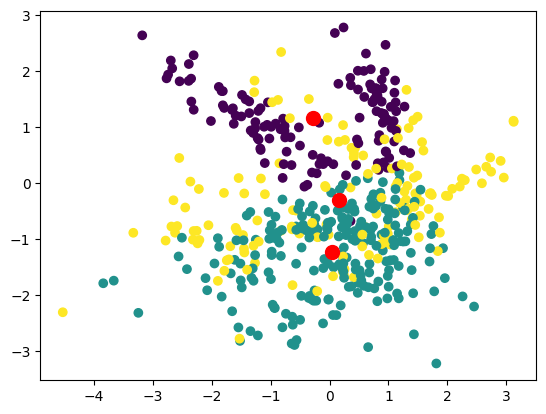

In [127]:
kmeans2 = KMeans(n_clusters=3).fit(data2)

plt.scatter(data2[:, 0], data2[:, 1], c=kmeans2.labels_)
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=100, c='red')

print_metrics(data2, data2_y, kmeans2.labels_)

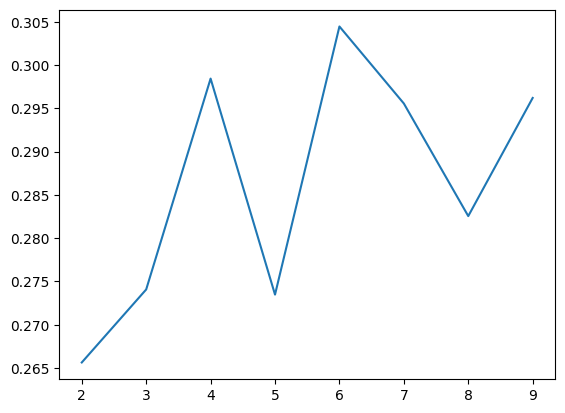

In [128]:
plt.plot(range(2, 10), [silhouette_score(data2, KMeans(i, n_init='auto').fit(data2).labels_) for i in range(2, 10)])

c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.67537	 (-> 1)
  fowlkes_mallows_score = 0.39322	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.30506	 (-> 1)
   davies_bouldin_score = 1.07113	 (-> 0)



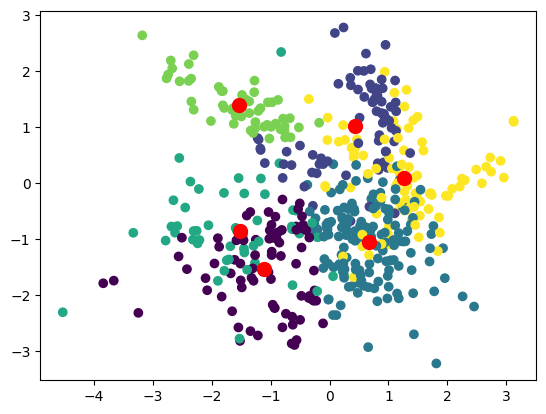

In [130]:
kmeans2 = KMeans(n_clusters=6).fit(data2)

plt.scatter(data2[:, 0], data2[:, 1], c=kmeans2.labels_)
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=100, c='red')

print_metrics(data2, data2_y, kmeans2.labels_)

{'silhouette_score': 0.30785752029338803, 'model': AffinityPropagation(damping=0.7999999999999999, random_state=73), 'params': {'damping': 0.7999999999999999, 'verbose': False, 'random_state': 73}}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.68698	 (-> 1)
  fowlkes_mallows_score = 0.25541	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.30786	 (-> 1)
   davies_bouldin_score = 0.87515	 (-> 0)



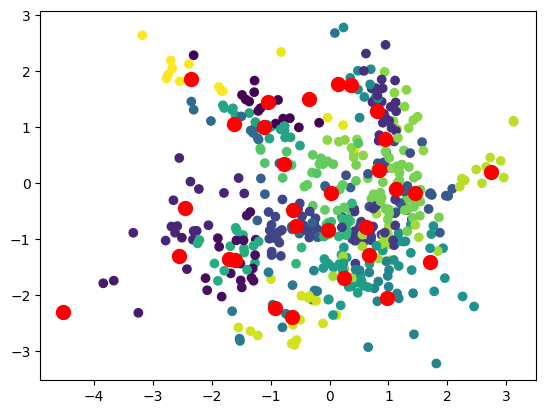

In [132]:
params = {
    'damping': np.arange(0.5, 1, 0.1),
    'verbose': [False],
    'random_state': [73],
}

best = find_best(AffinityPropagation, data2, params)
print(best)

afp2: AffinityPropagation = best['model']

plt.scatter(data2[:, 0], data2[:, 1], c=afp2.labels_)
plt.scatter(afp2.cluster_centers_[:, 0], afp2.cluster_centers_[:, 1], s=100, c='red')

print_metrics(data2, data2_y, afp2.labels_)

{'eps': 1.0}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.34653	 (-> 1)
  fowlkes_mallows_score = 0.56368	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.39347	 (-> 1)
   davies_bouldin_score = 3.31647	 (-> 0)



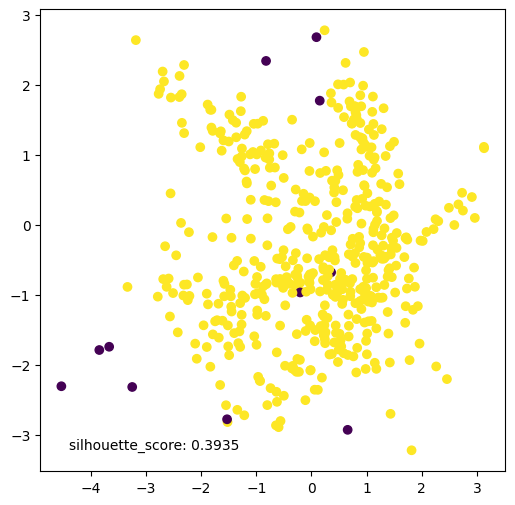

{'eps': 1.1}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.34526	 (-> 1)
  fowlkes_mallows_score = 0.56482	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.40960	 (-> 1)
   davies_bouldin_score = 3.11678	 (-> 0)



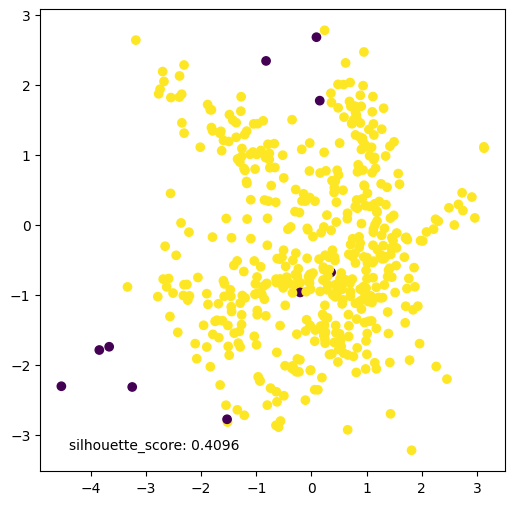

{'eps': 1.2000000000000002}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.34268	 (-> 1)
  fowlkes_mallows_score = 0.56710	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.42714	 (-> 1)
   davies_bouldin_score = 3.46084	 (-> 0)



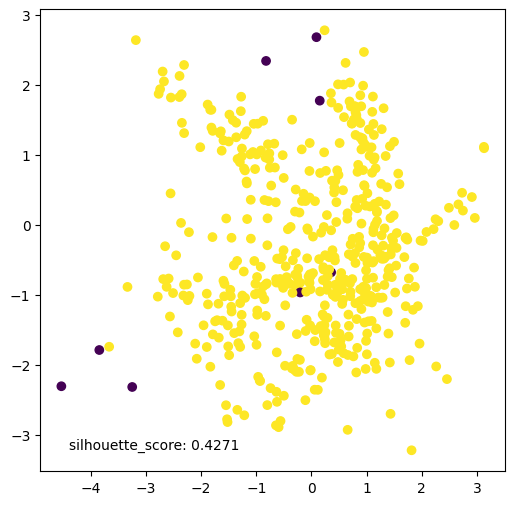

{'eps': 1.3000000000000003}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.33998	 (-> 1)
  fowlkes_mallows_score = 0.56931	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.44363	 (-> 1)
   davies_bouldin_score = 4.66606	 (-> 0)



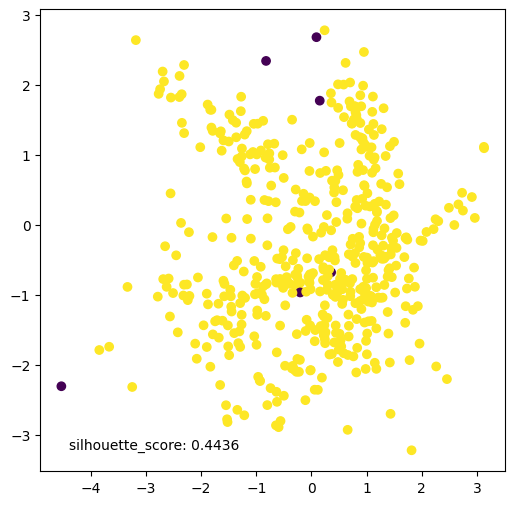

{'eps': 1.4000000000000004}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.33998	 (-> 1)
  fowlkes_mallows_score = 0.56931	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.44363	 (-> 1)
   davies_bouldin_score = 4.66606	 (-> 0)



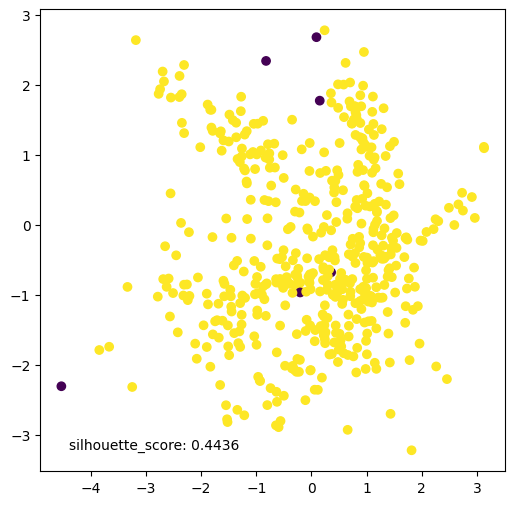

{'eps': 1.5000000000000004}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.33998	 (-> 1)
  fowlkes_mallows_score = 0.56931	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.44363	 (-> 1)
   davies_bouldin_score = 4.66606	 (-> 0)



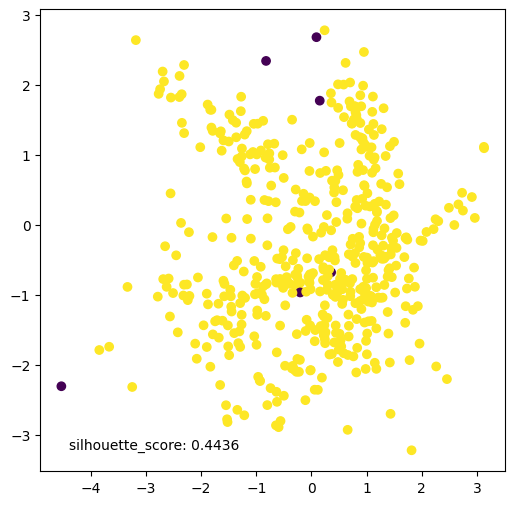

{'eps': 1.6000000000000005}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.33608	 (-> 1)
  fowlkes_mallows_score = 0.57280	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.47881	 (-> 1)
   davies_bouldin_score = 1.97553	 (-> 0)



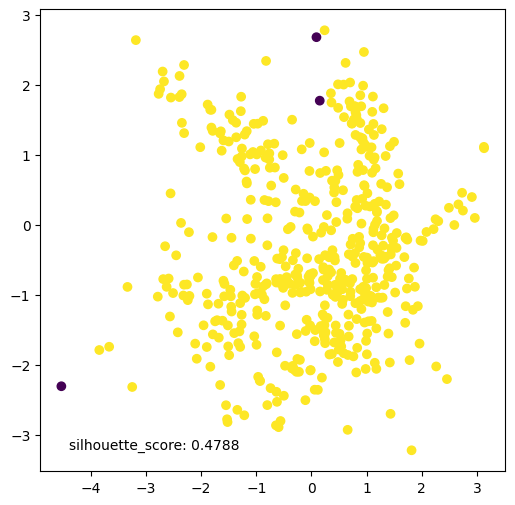

{'eps': 1.7000000000000006}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.33471	 (-> 1)
  fowlkes_mallows_score = 0.57391	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.50025	 (-> 1)
   davies_bouldin_score = 2.44539	 (-> 0)



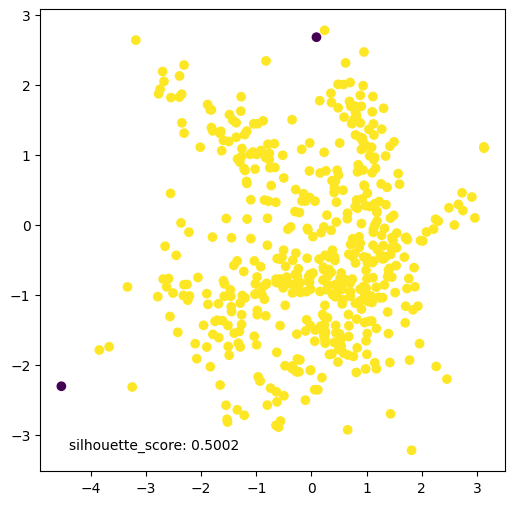

{'eps': 1.8000000000000007}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.33471	 (-> 1)
  fowlkes_mallows_score = 0.57391	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.50025	 (-> 1)
   davies_bouldin_score = 2.44539	 (-> 0)



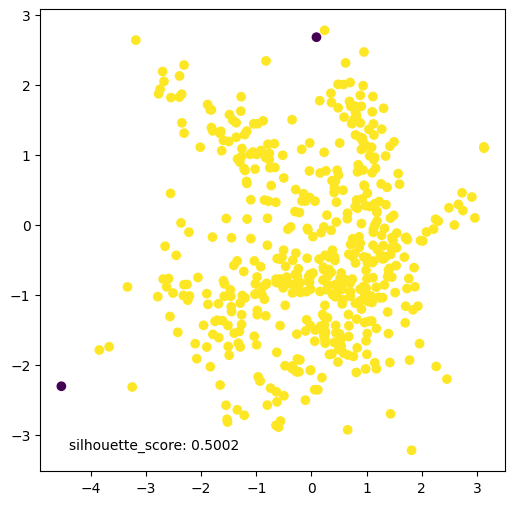

{'eps': 1.9000000000000008}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.33471	 (-> 1)
  fowlkes_mallows_score = 0.57391	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.50025	 (-> 1)
   davies_bouldin_score = 2.44539	 (-> 0)



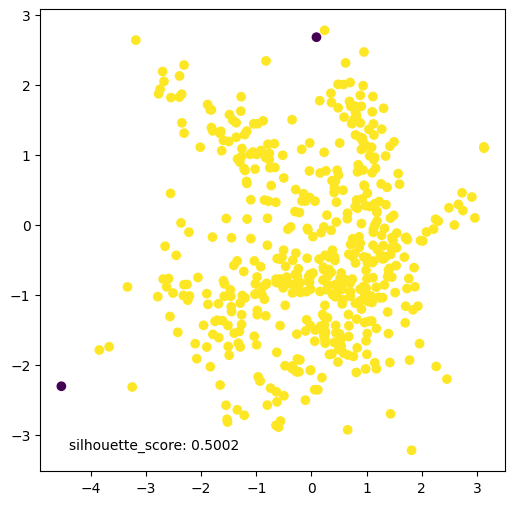

In [199]:

params = {
    'eps': np.arange(1, 2, 0.1),
}

res = []
for grid in grid_search(params):
    model = DBSCAN(**grid).fit(data2)
    res.append({
        'silhouette_score': silhouette_score(data2, model.labels_),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data2, data2_y, info['model'].labels_)
    plt.figure(figsize=(6, 6))
    plt.scatter(data2[:, 0], data2[:, 1], c=info['model'].labels_)
    plt.text(-4.4, -3.2, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

{'n_components': 2}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.51421	 (-> 1)
  fowlkes_mallows_score = 0.49336	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.27369	 (-> 1)
   davies_bouldin_score = 1.46745	 (-> 0)



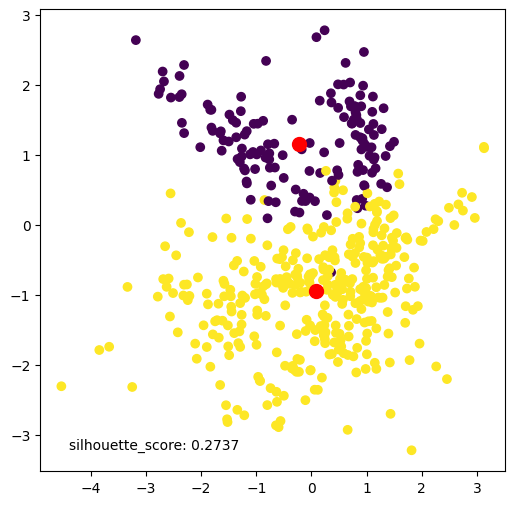

{'n_components': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.63907	 (-> 1)
  fowlkes_mallows_score = 0.46661	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.16314	 (-> 1)
   davies_bouldin_score = 2.21485	 (-> 0)



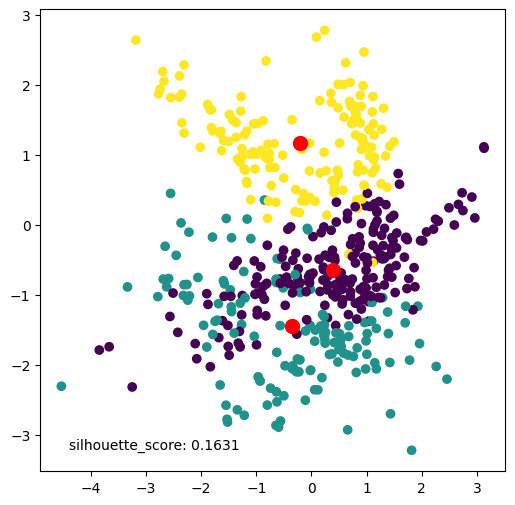

{'n_components': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.65446	 (-> 1)
  fowlkes_mallows_score = 0.41606	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.19081	 (-> 1)
   davies_bouldin_score = 1.37751	 (-> 0)



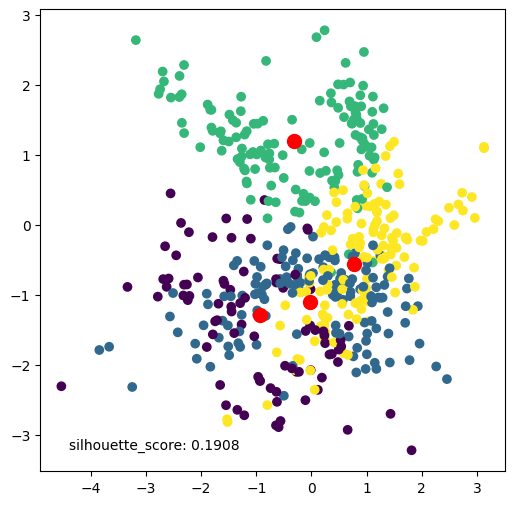

{'n_components': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.72327	 (-> 1)
  fowlkes_mallows_score = 0.50527	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.14845	 (-> 1)
   davies_bouldin_score = 1.44653	 (-> 0)



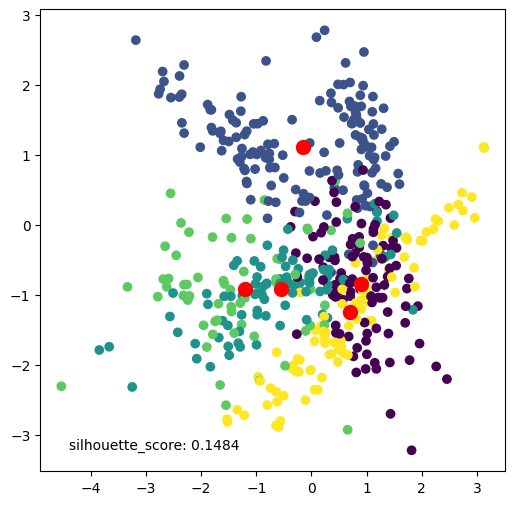

{'n_components': 6}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.77422	 (-> 1)
  fowlkes_mallows_score = 0.58071	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.18532	 (-> 1)
   davies_bouldin_score = 1.43418	 (-> 0)



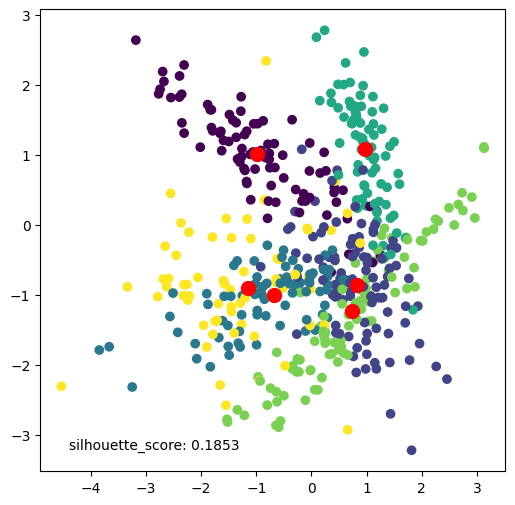

In [200]:

params = {
    'n_components': [2, 3, 4, 5, 6],
}

res = []
for grid in grid_search(params):
    model = GaussianMixture(**grid).fit(data2)
    res.append({
        'silhouette_score': silhouette_score(data2, model.predict(data2)),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data2, data2_y, info['model'].predict(data2))
    plt.figure(figsize=(6, 6))
    plt.scatter(data2[:, 0], data2[:, 1], c=info['model'].predict(data2))
    plt.scatter(info['model'].means_[:, 0], info['model'].means_[:, 1], s=100, c='red')
    plt.text(-4.4, -3.2, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

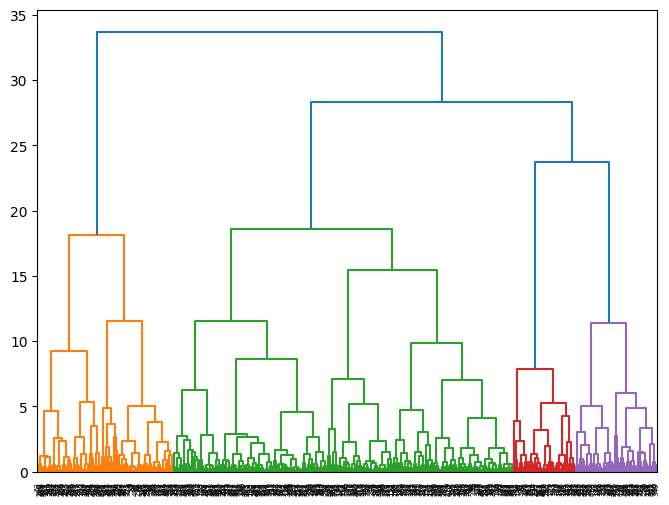

In [154]:
clusters2 = hierarchy.linkage(data2, method="ward")
plt.figure(figsize=(8, 6))
plt.show(hierarchy.dendrogram(clusters2))

{'n_clusters': 2}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.47917	 (-> 1)
  fowlkes_mallows_score = 0.50061	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.28100	 (-> 1)
   davies_bouldin_score = 1.37994	 (-> 0)



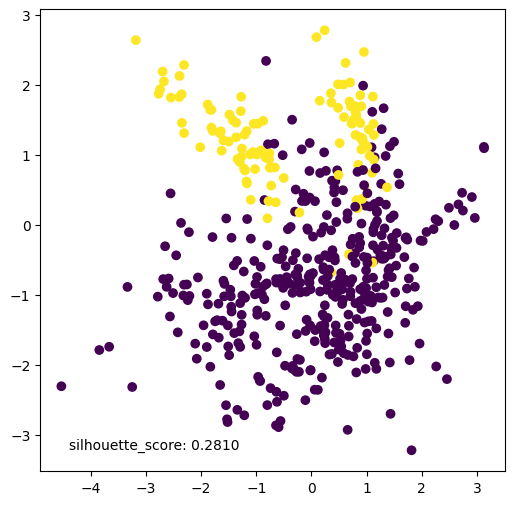

{'n_clusters': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.59444	 (-> 1)
  fowlkes_mallows_score = 0.44899	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.26527	 (-> 1)
   davies_bouldin_score = 1.41890	 (-> 0)



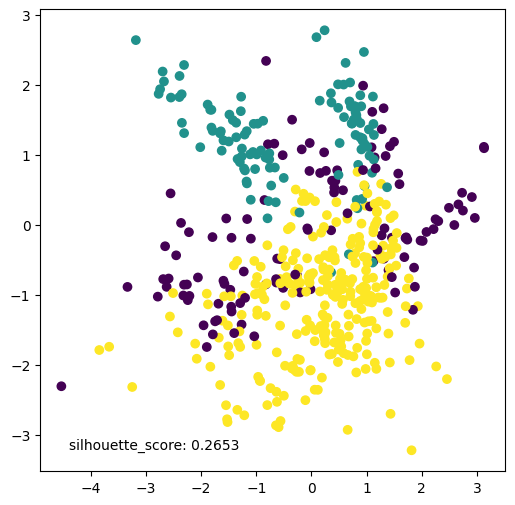

{'n_clusters': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.60552	 (-> 1)
  fowlkes_mallows_score = 0.44277	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.27225	 (-> 1)
   davies_bouldin_score = 1.10516	 (-> 0)



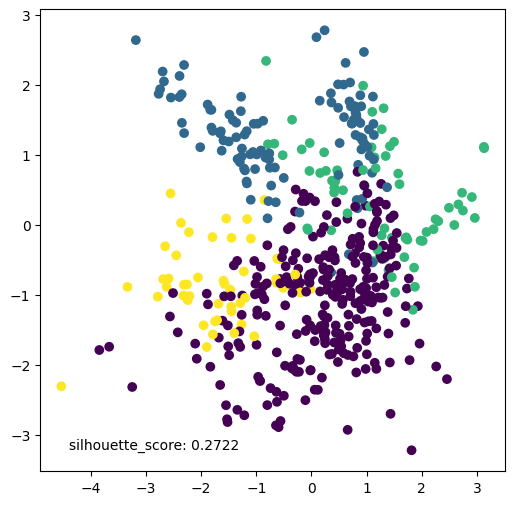

{'n_clusters': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.64695	 (-> 1)
  fowlkes_mallows_score = 0.37391	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.22579	 (-> 1)
   davies_bouldin_score = 1.23424	 (-> 0)



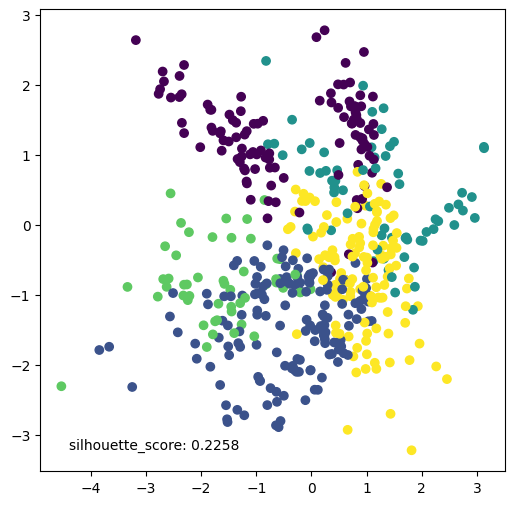

{'n_clusters': 6}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.66300	 (-> 1)
  fowlkes_mallows_score = 0.37998	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.25824	 (-> 1)
   davies_bouldin_score = 1.18356	 (-> 0)



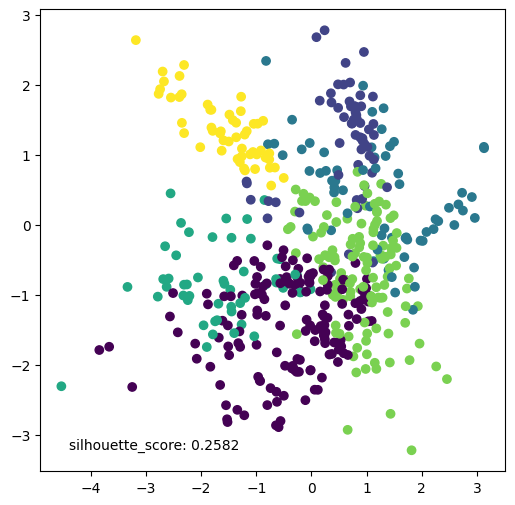

In [201]:

params = {
    'n_clusters': [2, 3, 4, 5, 6],
}

res = []
for grid in grid_search(params):
    model = AgglomerativeClustering(**grid).fit(data2)
    res.append({
        'silhouette_score': silhouette_score(data2, model.labels_),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data2, data2_y, info['model'].labels_)
    plt.figure(figsize=(6, 6))
    plt.scatter(data2[:, 0], data2[:, 1], c=info['model'].labels_)
    plt.text(-4.4, -3.2, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

{'silhouette_score': 0.21044528732870885, 'model': <sklearn_som.som.SOM object at 0x0000022039EBE2E0>, 'params': {'dim': 3, 'random_state': 73, 'n': 5, 'm': 3, 'lr': 2, 'sigma': 1}}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.69397	 (-> 1)
  fowlkes_mallows_score = 0.31607	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.21045	 (-> 1)
   davies_bouldin_score = 1.27628	 (-> 0)



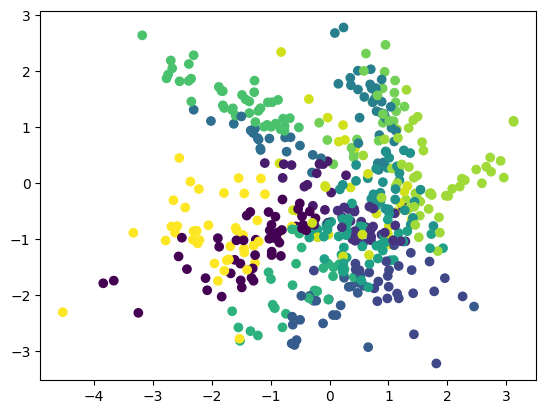

In [188]:
params = {
    'dim': [3],
    'random_state': [73],
    'n': range(3, 6),
    'm': range(3, 6),
    'lr': [1, 2, 3],
    'sigma': [1, 2, 3],
}

res = []
for grid in grid_search(params):
    model: SOM = SOM(**grid)
    res.append({
        'silhouette_score': silhouette_score(data2, model.fit_predict(data2)),
        'model': model,
        'params': grid,
    })

best = max(res, key=lambda x: x['silhouette_score'])
print(best)

som2: SOM = best['model']
print_metrics(data2, data2_y, som2.predict(data2))

plt.scatter(data2[:, 0], data2[:, 1], c=som2.predict(data2))

Получился ахалай махалай

## data3


= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.98172	 (-> 1)
  fowlkes_mallows_score = 0.95393	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.60865	 (-> 1)
   davies_bouldin_score = 0.54947	 (-> 0)



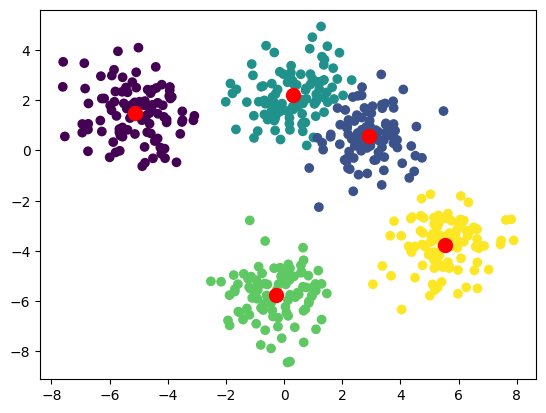

In [164]:
km3 = KM(n_clusters=5).fit(data3)

print_metrics(data3, data3_y, km3.labels_)

plt.scatter(data3[:, 0], data3[:, 1], c=km3.labels_)
plt.scatter(km3.cluster_centers_[:, 0], km3.cluster_centers_[:, 1], s=100, c='red')

c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` 

{'n_clusters': 2}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.65939	 (-> 1)
  fowlkes_mallows_score = 0.56704	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.44407	 (-> 1)
   davies_bouldin_score = 0.95079	 (-> 0)



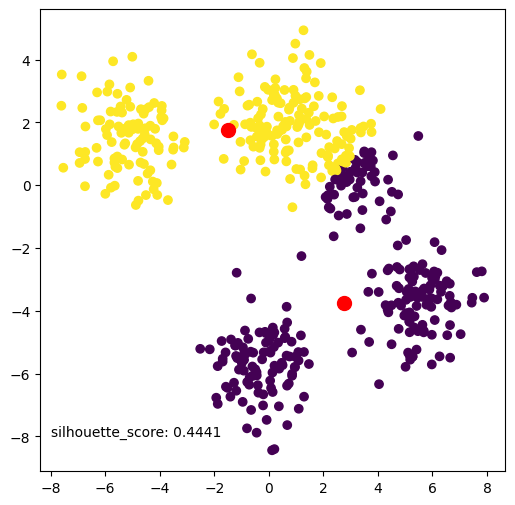

{'n_clusters': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.83490	 (-> 1)
  fowlkes_mallows_score = 0.73345	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.54085	 (-> 1)
   davies_bouldin_score = 0.69440	 (-> 0)



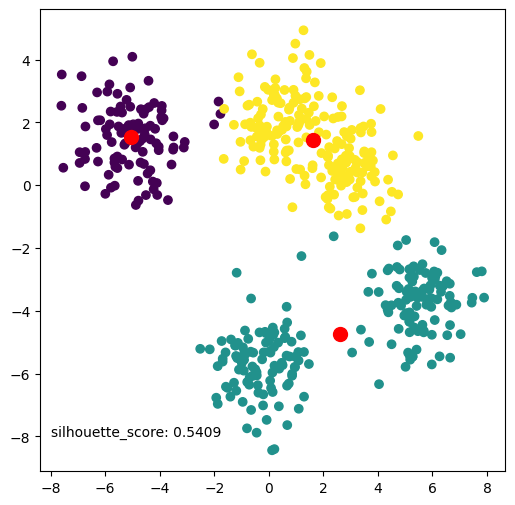

{'n_clusters': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.91513	 (-> 1)
  fowlkes_mallows_score = 0.83103	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.63753	 (-> 1)
   davies_bouldin_score = 0.45600	 (-> 0)



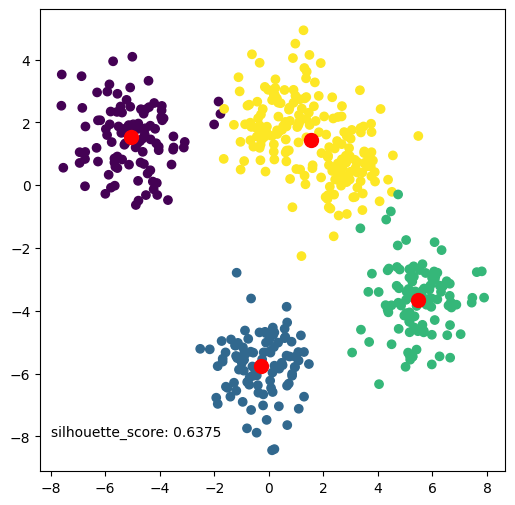

{'n_clusters': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.98172	 (-> 1)
  fowlkes_mallows_score = 0.95393	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.60865	 (-> 1)
   davies_bouldin_score = 0.54947	 (-> 0)



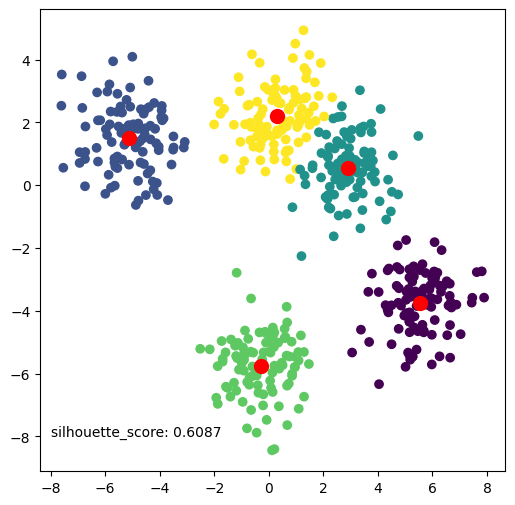

{'n_clusters': 6}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.96421	 (-> 1)
  fowlkes_mallows_score = 0.90589	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.56689	 (-> 1)
   davies_bouldin_score = 0.66619	 (-> 0)



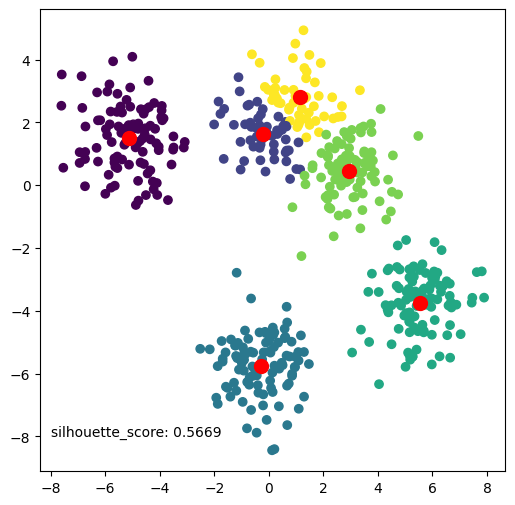

In [202]:

params = {
    'n_clusters': [2, 3, 4, 5, 6],
}

res = []
for grid in grid_search(params):
    model = KMeans(**grid).fit(data3)
    res.append({
        'silhouette_score': silhouette_score(data3, model.labels_),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data3, data3_y, info['model'].labels_)
    plt.figure(figsize=(6, 6))
    plt.scatter(data3[:, 0], data3[:, 1], c=info['model'].labels_)
    plt.scatter(info['model'].cluster_centers_[:, 0], info['model'].cluster_centers_[:, 1], s=100, c='red')
    plt.text(-8, -8, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

{'silhouette_score': 0.34209073807085066, 'model': AffinityPropagation(random_state=73), 'params': {'damping': 0.5, 'verbose': False, 'random_state': 73}}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.87129	 (-> 1)
  fowlkes_mallows_score = 0.59340	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.34209	 (-> 1)
   davies_bouldin_score = 0.93842	 (-> 0)



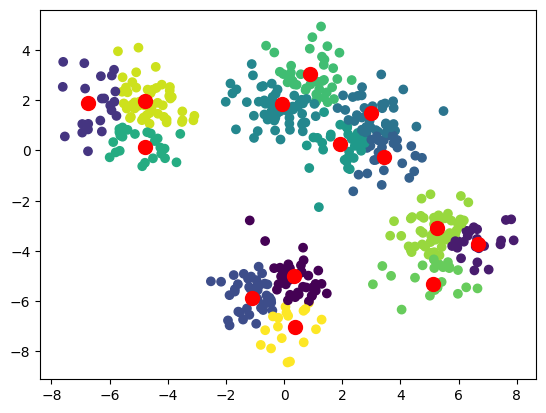

In [174]:
params = {
    'damping': np.arange(0.5, 1, 0.1),
    'verbose': [False],
    'random_state': [73],
}

best = find_best(AffinityPropagation, data3, params)
print(best)

afp3: AffinityPropagation = best['model']

plt.scatter(data3[:, 0], data3[:, 1], c=afp3.labels_)
plt.scatter(afp3.cluster_centers_[:, 0], afp3.cluster_centers_[:, 1], s=100, c='red')

print_metrics(data3, data3_y, afp3.labels_)

{'silhouette_score': 0.6247915515218317, 'model': DBSCAN(eps=0.9000000000000001, leaf_size=15, min_samples=4), 'params': {'eps': 0.9000000000000001, 'min_samples': 4, 'leaf_size': 15}}
[-1  0  1  2  3]

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.91343	 (-> 1)
  fowlkes_mallows_score = 0.82639	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.62479	 (-> 1)
   davies_bouldin_score = 1.58947	 (-> 0)



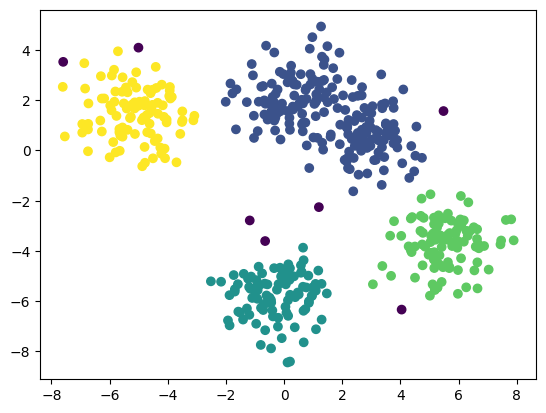

In [183]:
params = {
    'eps': np.arange(0.3, 1, 0.1),
    'min_samples': range(3, 8),
    'leaf_size': range(15, 41, 5),
}

best = find_best(DBSCAN, data3, params)
print(best)

dbscan3: DBSCAN = best['model']

print(np.unique(dbscan3.labels_))
plt.scatter(data3[:, 0], data3[:, 1], c=dbscan3.labels_)

print_metrics(data3, data3_y, dbscan3.labels_)

{'n_components': 2}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.67857	 (-> 1)
  fowlkes_mallows_score = 0.61625	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.47332	 (-> 1)
   davies_bouldin_score = 0.92821	 (-> 0)



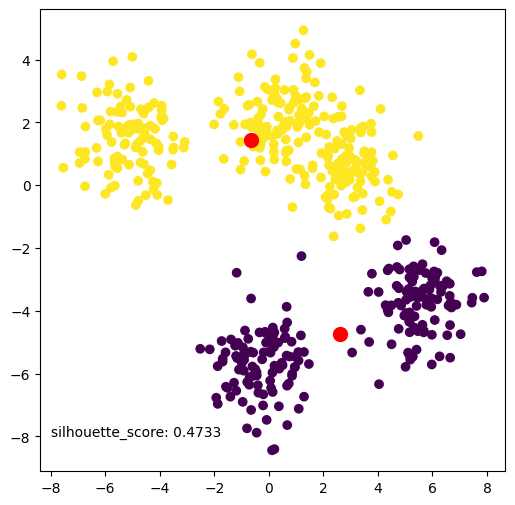

{'n_components': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.79993	 (-> 1)
  fowlkes_mallows_score = 0.67190	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.46429	 (-> 1)
   davies_bouldin_score = 0.75372	 (-> 0)



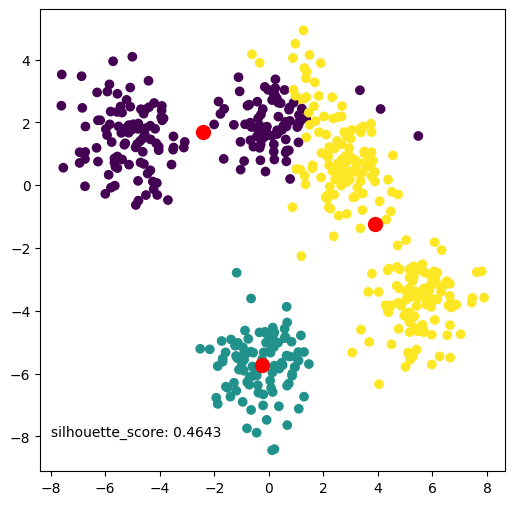

{'n_components': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.91744	 (-> 1)
  fowlkes_mallows_score = 0.83934	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.63852	 (-> 1)
   davies_bouldin_score = 0.45324	 (-> 0)



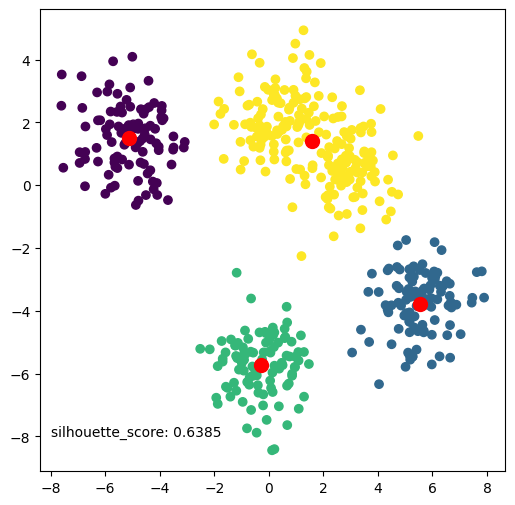

{'n_components': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.98172	 (-> 1)
  fowlkes_mallows_score = 0.95393	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.60865	 (-> 1)
   davies_bouldin_score = 0.54947	 (-> 0)



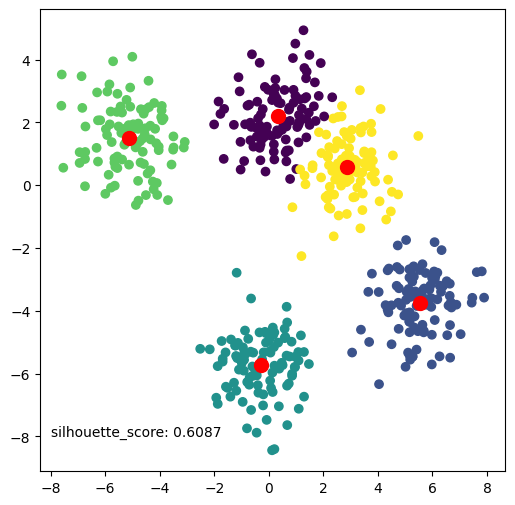

{'n_components': 6}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.96241	 (-> 1)
  fowlkes_mallows_score = 0.90162	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.53553	 (-> 1)
   davies_bouldin_score = 0.80007	 (-> 0)



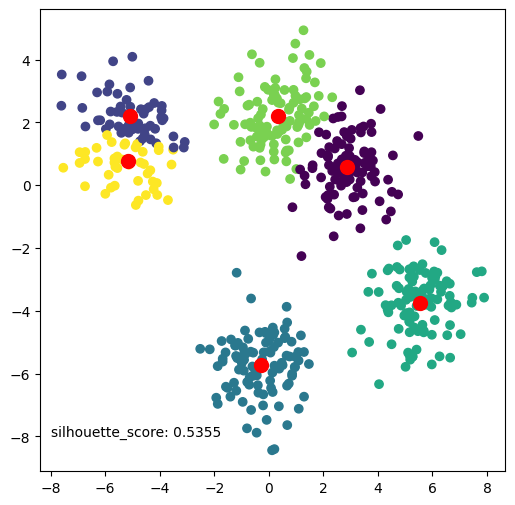

In [203]:
params = {
    'n_components': [2, 3, 4, 5, 6],
}

res = []
for grid in grid_search(params):
    model = GaussianMixture(**grid).fit(data3)
    res.append({
        'silhouette_score': silhouette_score(data3, model.predict(data3)),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data3, data3_y, info['model'].predict(data3))
    plt.figure(figsize=(6, 6))
    plt.scatter(data3[:, 0], data3[:, 1], c=info['model'].predict(data3))
    plt.scatter(info['model'].means_[:, 0], info['model'].means_[:, 1], s=100, c='red')
    plt.text(-8, -8, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

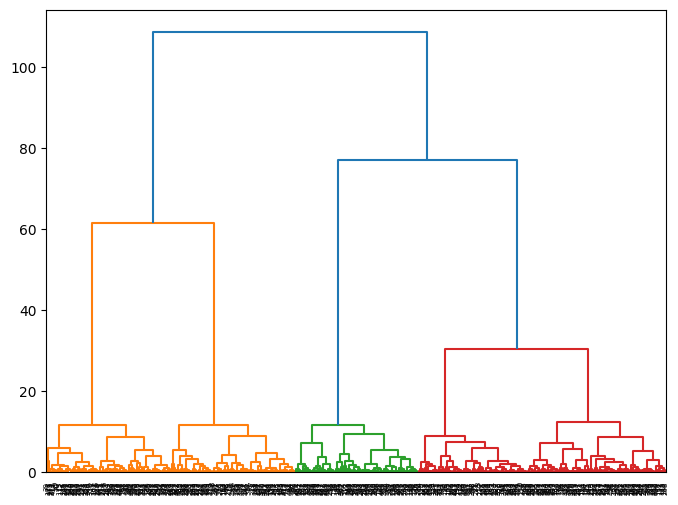

In [186]:
clusters3 = hierarchy.linkage(data3, method="ward")
plt.figure(figsize=(8, 6))
plt.show(hierarchy.dendrogram(clusters3))

{'n_clusters': 2}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.67857	 (-> 1)
  fowlkes_mallows_score = 0.61625	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.47332	 (-> 1)
   davies_bouldin_score = 0.92821	 (-> 0)



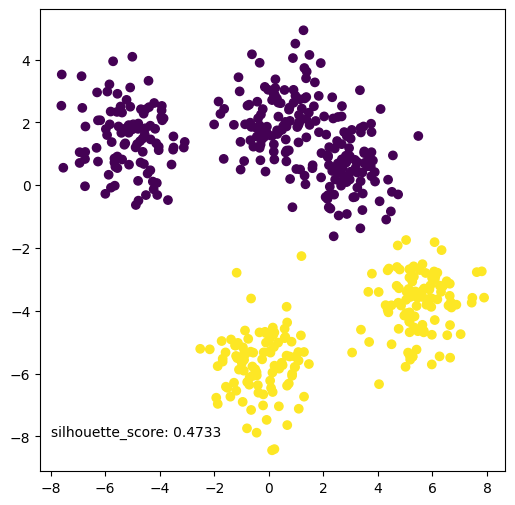

{'n_clusters': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.83570	 (-> 1)
  fowlkes_mallows_score = 0.73691	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.54281	 (-> 1)
   davies_bouldin_score = 0.69392	 (-> 0)



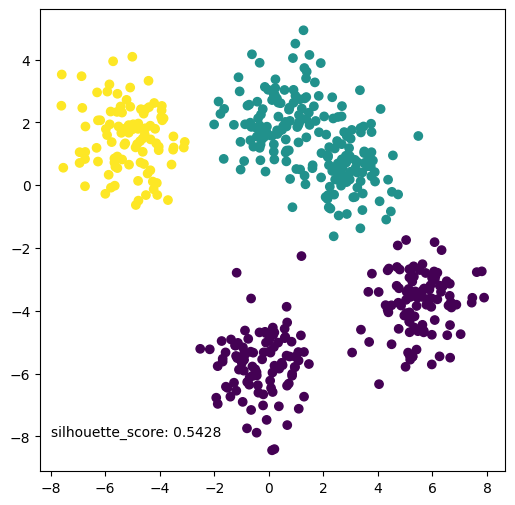

{'n_clusters': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.91666	 (-> 1)
  fowlkes_mallows_score = 0.83717	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.63848	 (-> 1)
   davies_bouldin_score = 0.45260	 (-> 0)



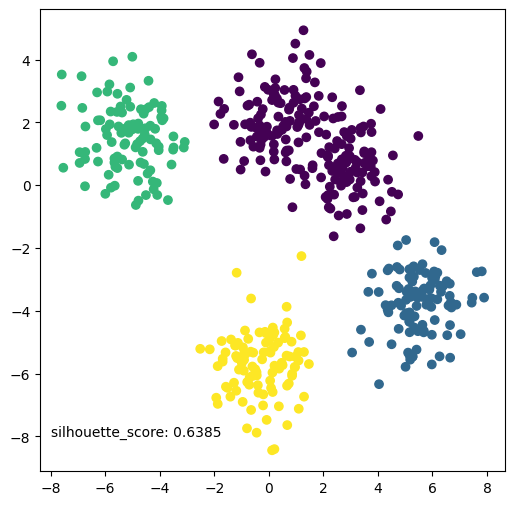

{'n_clusters': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.97460	 (-> 1)
  fowlkes_mallows_score = 0.93617	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.60046	 (-> 1)
   davies_bouldin_score = 0.55287	 (-> 0)



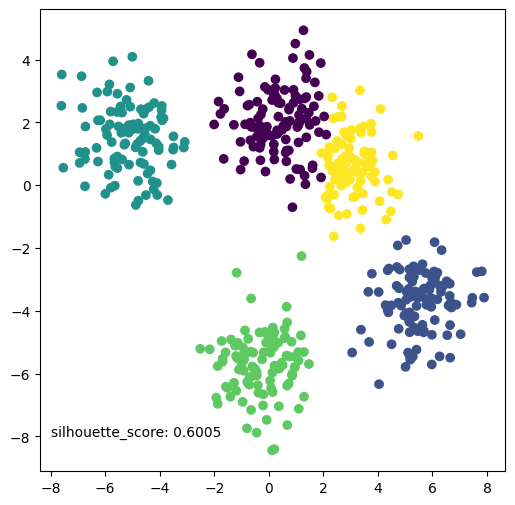

{'n_clusters': 6}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.96086	 (-> 1)
  fowlkes_mallows_score = 0.89690	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.55868	 (-> 1)
   davies_bouldin_score = 0.70451	 (-> 0)



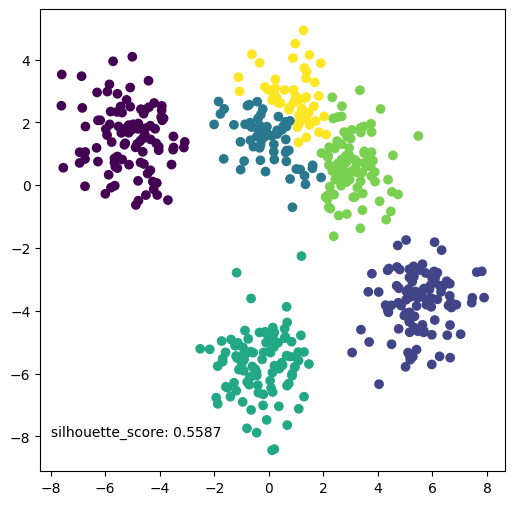

In [204]:
params = {
    'n_clusters': [2, 3, 4, 5, 6],
}

res = []
for grid in grid_search(params):
    model = AgglomerativeClustering(**grid).fit(data3)
    res.append({
        'silhouette_score': silhouette_score(data3, model.labels_),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data3, data3_y, info['model'].labels_)
    plt.figure(figsize=(6, 6))
    plt.scatter(data3[:, 0], data3[:, 1], c=info['model'].labels_)
    plt.text(-8, -8, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()

{'silhouette_score': 0.4259061630281308, 'model': <sklearn_som.som.SOM object at 0x000002202E32DDC0>, 'params': {'dim': 2, 'random_state': 73, 'n': 3, 'm': 3, 'lr': 2, 'sigma': 1}}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.94308	 (-> 1)
  fowlkes_mallows_score = 0.84584	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.42591	 (-> 1)
   davies_bouldin_score = 0.88040	 (-> 0)



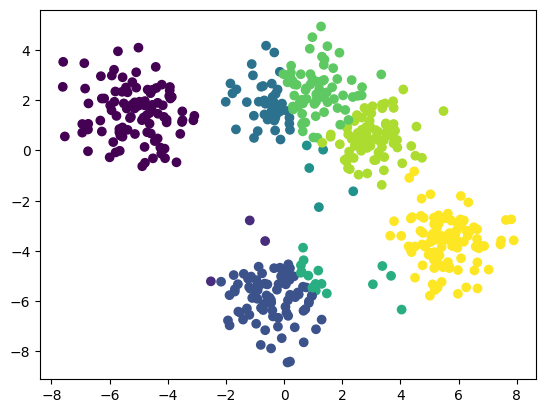

In [191]:
params = {
    'dim': [2],
    'random_state': [73],
    'n': range(3, 6),
    'm': range(3, 6),
    'lr': [1, 2, 3],
    'sigma': [1, 2, 3],
}

res = []
for grid in grid_search(params):
    model: SOM = SOM(**grid)
    res.append({
        'silhouette_score': silhouette_score(data3, model.fit_predict(data3)),
        'model': model,
        'params': grid,
    })

best = max(res, key=lambda x: x['silhouette_score'])
print(best)

som3: SOM = best['model']
print_metrics(data3, data3_y, som3.predict(data3))

plt.scatter(data3[:, 0], data3[:, 1], c=som3.predict(data3))

{'dim': 2, 'random_state': 73, 'n': 3, 'm': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.94903	 (-> 1)
  fowlkes_mallows_score = 0.86367	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.41587	 (-> 1)
   davies_bouldin_score = 0.82510	 (-> 0)



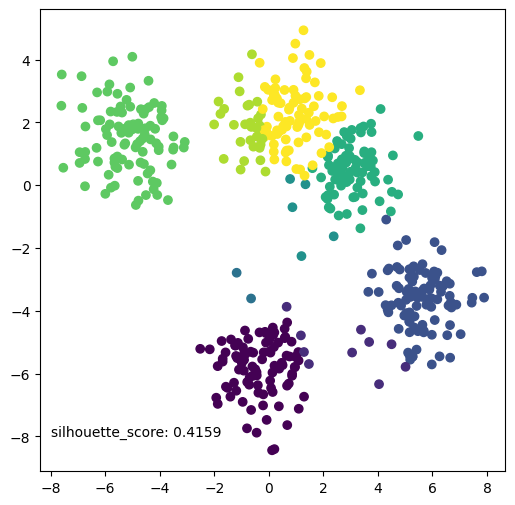

{'dim': 2, 'random_state': 73, 'n': 3, 'm': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.91437	 (-> 1)
  fowlkes_mallows_score = 0.75530	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.28507	 (-> 1)
   davies_bouldin_score = 0.99086	 (-> 0)



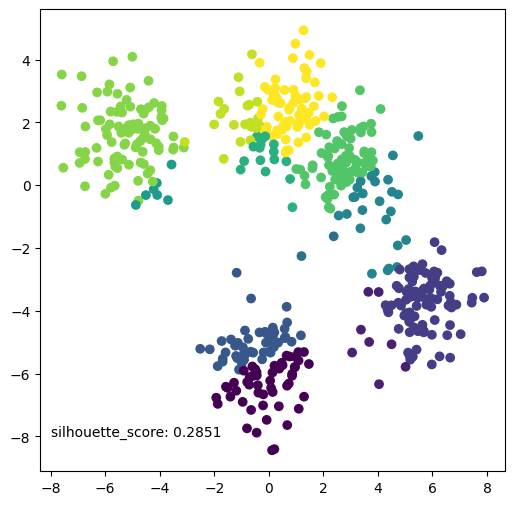

{'dim': 2, 'random_state': 73, 'n': 3, 'm': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.90168	 (-> 1)
  fowlkes_mallows_score = 0.71064	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.27072	 (-> 1)
   davies_bouldin_score = 1.00581	 (-> 0)



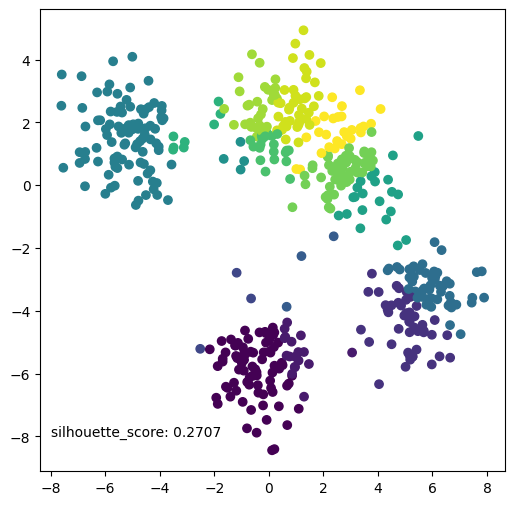

{'dim': 2, 'random_state': 73, 'n': 4, 'm': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.93520	 (-> 1)
  fowlkes_mallows_score = 0.82214	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.30530	 (-> 1)
   davies_bouldin_score = 0.95811	 (-> 0)



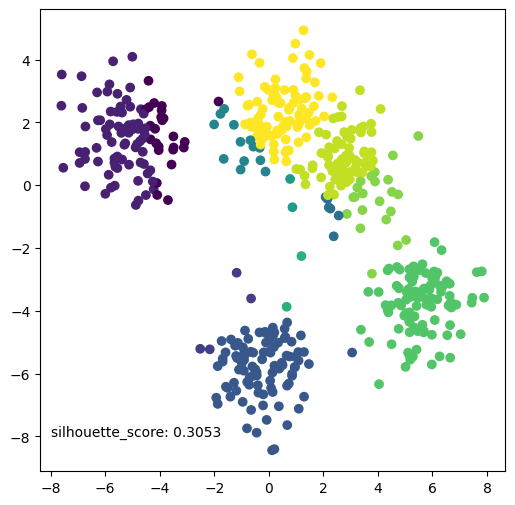

{'dim': 2, 'random_state': 73, 'n': 4, 'm': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.89862	 (-> 1)
  fowlkes_mallows_score = 0.70061	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.24731	 (-> 1)
   davies_bouldin_score = 0.97575	 (-> 0)



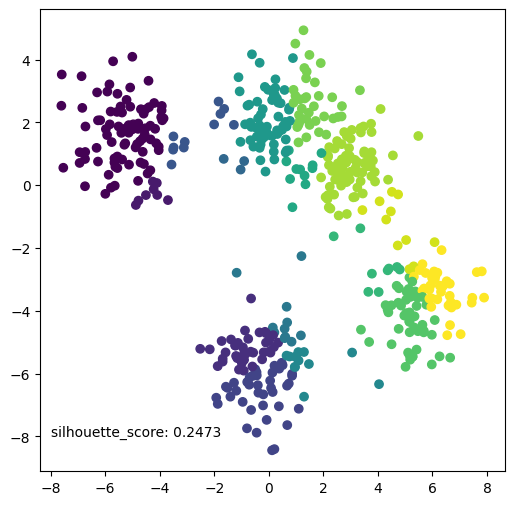

{'dim': 2, 'random_state': 73, 'n': 4, 'm': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.87537	 (-> 1)
  fowlkes_mallows_score = 0.61140	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.21997	 (-> 1)
   davies_bouldin_score = 1.00250	 (-> 0)



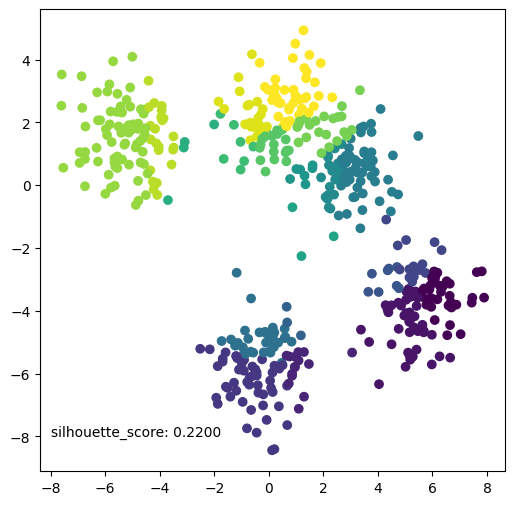

{'dim': 2, 'random_state': 73, 'n': 5, 'm': 3}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.89669	 (-> 1)
  fowlkes_mallows_score = 0.69275	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.25601	 (-> 1)
   davies_bouldin_score = 1.05479	 (-> 0)



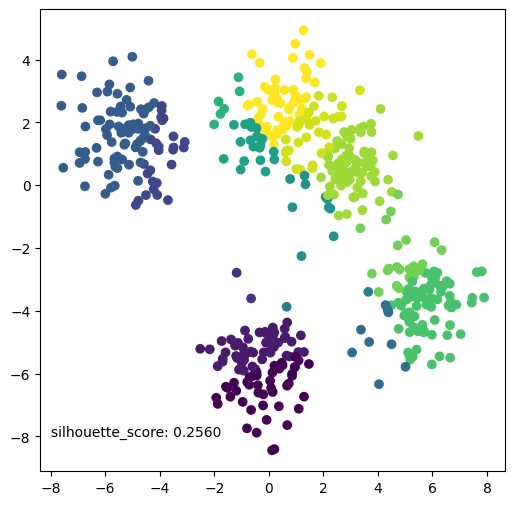

{'dim': 2, 'random_state': 73, 'n': 5, 'm': 4}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.88075	 (-> 1)
  fowlkes_mallows_score = 0.63178	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.23758	 (-> 1)
   davies_bouldin_score = 1.04786	 (-> 0)



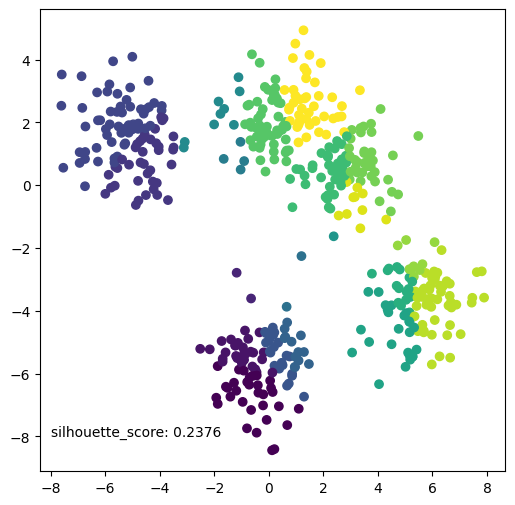

{'dim': 2, 'random_state': 73, 'n': 5, 'm': 5}

= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.86191	 (-> 1)
  fowlkes_mallows_score = 0.55238	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.20744	 (-> 1)
   davies_bouldin_score = 0.97979	 (-> 0)



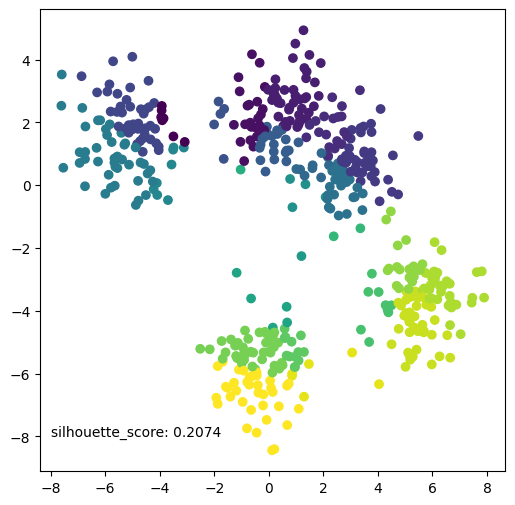

In [205]:
params = {
    'dim': [2],
    'random_state': [73],
    'n': range(3, 6),
    'm': range(3, 6),
}

res = []
for grid in grid_search(params):
    model = SOM(**grid)
    res.append({
        'silhouette_score': silhouette_score(data3, model.fit_predict(data3)),
        'model': model,
        'params': grid,
    })

for info in res:
    print(info['params'])
    print_metrics(data3, data3_y, info['model'].predict(data3))
    plt.figure(figsize=(6, 6))
    plt.scatter(data3[:, 0], data3[:, 1], c=info['model'].fit_predict(data3))
    plt.text(-8, -8, f'silhouette_score: {info["silhouette_score"]:.4f}')
    plt.show()